In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
#from lib import RadioUNet_modules3, RadioUNet_loaders2
from lib import loaders, modules

## Dataset Loader, RadioUNetc threshold=0.2

In [3]:


Radio_train = loaders.RadioUNet_c(phase="train")
Radio_val = loaders.RadioUNet_c(phase="val")
Radio_test = loaders.RadioUNet_c(phase="test")

image_datasets = {
    'train': Radio_train, 'val': Radio_val
}

batch_size = 15

dataloaders = {
    'train': DataLoader(Radio_train, batch_size=batch_size, shuffle=True, num_workers=1),
    'val': DataLoader(Radio_val, batch_size=batch_size, shuffle=True, num_workers=1)
}


## Test Sample Image

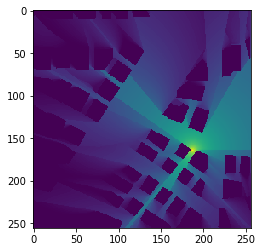

In [4]:
i=1000
image_build_ant, image_gain = Radio_train[i]
plt.imshow(image_gain[0])

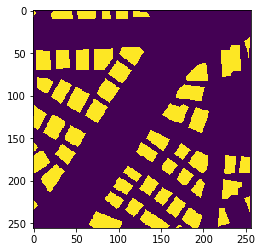

In [5]:
plt.imshow(image_build_ant[0])

## Load Model and Summary

In [6]:
from torchsummary import summary

torch.set_default_dtype(torch.float32)
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.backends.cudnn.enabled
model =modules.RadioWNet(phase="firstU")
model.cuda()
summary(model, input_size=(2, 256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 256, 256]             114
              ReLU-2          [-1, 6, 256, 256]               0
         MaxPool2d-3          [-1, 6, 256, 256]               0
            Conv2d-4         [-1, 40, 256, 256]           6,040
              ReLU-5         [-1, 40, 256, 256]               0
         MaxPool2d-6         [-1, 40, 128, 128]               0
            Conv2d-7         [-1, 50, 128, 128]          50,050
              ReLU-8         [-1, 50, 128, 128]               0
         MaxPool2d-9           [-1, 50, 64, 64]               0
           Conv2d-10           [-1, 60, 64, 64]          75,060
             ReLU-11           [-1, 60, 64, 64]               0
        MaxPool2d-12           [-1, 60, 64, 64]               0
           Conv2d-13          [-1, 100, 64, 64]         150,100
             ReLU-14          [-1, 100,

## Training Loop

In [10]:
#Adapted from https://github.com/usuyama/pytorch-unet

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.nn as nn

def calc_loss_dense(pred, target, metrics):
    criterion = nn.MSELoss()
    loss = criterion(pred, target)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def calc_loss_sparse(pred, target, samples, metrics, num_samples):
    criterion = nn.MSELoss()
    loss = criterion(samples*pred, samples*target)*(256**2)/num_samples
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs1 = []
    outputs2 = []
    for k in metrics.keys():
        outputs1.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs1)))

def train_model(model, optimizer, scheduler, num_epochs=50, WNetPhase="firstU", targetType="dense", num_samples=300):
    # WNetPhase: traine first U and freez second ("firstU"), or vice verse ("secondU").
    # targetType: train against dense images ("dense") or sparse measurements ("sparse")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("learning rate", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            if targetType=="dense":
                for inputs, targets in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        [outputs1,outputs2] = model(inputs)
                        if WNetPhase=="firstU":
                            loss = calc_loss_dense(outputs1, targets, metrics)
                        else:
                            loss = calc_loss_dense(outputs2, targets, metrics)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    epoch_samples += inputs.size(0)
            elif targetType=="sparse":
                for inputs, targets, samples in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    samples = samples.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        [outputs1,outputs2] = model(inputs)
                        if WNetPhase=="firstU":
                            loss = calc_loss_sparse(outputs1, targets, samples, metrics, num_samples)
                        else:
                            loss = calc_loss_sparse(outputs2, targets, samples, metrics, num_samples)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Training First UNet


In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler)

cuda:0
Epoch 0/49
----------
learning rate 0.0001
train: loss: 0.008800
val: loss: 0.001594
saving best model
8m 24s
Epoch 1/49
----------
learning rate 0.0001
train: loss: 0.001260
val: loss: 0.001066
saving best model
8m 40s
Epoch 2/49
----------
learning rate 0.0001


## Create Directory For Saving the Model and Examples

In [17]:
import os
try: 
    os.mkdir('RadioWNet_c_DPM_Thr2') 
except OSError as error: 
    print(error) 

## Save First U Model For Inference

In [18]:
torch.save(model.state_dict(), 'RadioWNet_c_DPM_Thr2/Trained_Model_FirstU.pt')

## Load Second U Model For Inference

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = modules.RadioWNet(phase="firstU")
model.load_state_dict(torch.load('RadioWNet_c_DPM_Thr2/Trained_Model_FirstU.pt'))
model.to(device)

RadioWNet(
  (layer00): Sequential(
    (0): Conv2d(2, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer0): Sequential(
    (0): Conv2d(6, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(40, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer10): Sequential(
    (0): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(60, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
  

## Second U Module

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =modules.RadioWNet(phase="secondU")
model.load_state_dict(torch.load('RadioWNet_c_DPM_Thr2/Trained_Model_FirstU.pt'))
model.to(device)

RadioWNet(
  (layer00): Sequential(
    (0): Conv2d(2, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer0): Sequential(
    (0): Conv2d(6, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(40, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer10): Sequential(
    (0): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(60, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
  

## Training Scond UNet

In [21]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, WNetPhase="secondU")

cuda:0
Epoch 0/49
----------
learning rate 0.0001
train: loss: 0.000544
val: loss: 0.000451
saving best model
8m 11s
Epoch 1/49
----------
learning rate 0.0001
train: loss: 0.000135
val: loss: 0.000442
saving best model
8m 11s
Epoch 2/49
----------
learning rate 0.0001
train: loss: 0.000132
val: loss: 0.000441
saving best model
8m 11s
Epoch 3/49
----------
learning rate 0.0001
train: loss: 0.000131
val: loss: 0.000442
8m 11s
Epoch 4/49
----------
learning rate 0.0001
train: loss: 0.000131
val: loss: 0.000440
saving best model
8m 11s
Epoch 5/49
----------
learning rate 0.0001
train: loss: 0.000130
val: loss: 0.000440
saving best model
8m 11s
Epoch 6/49
----------
learning rate 0.0001
train: loss: 0.000130
val: loss: 0.000439
saving best model
8m 11s
Epoch 7/49
----------
learning rate 0.0001
train: loss: 0.000129
val: loss: 0.000438
saving best model
8m 11s
Epoch 8/49
----------
learning rate 0.0001
train: loss: 0.000127
val: loss: 0.000437
saving best model
8m 11s
Epoch 9/49
----------

## Save Second U Model For Inference

In [22]:
torch.save(model.state_dict(), 'RadioWNet_c_DPM_Thr2/Trained_Model_SecondU.pt')

## Load Second U Model For Inference

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = modules.RadioWNet(phase="secondU")
model.load_state_dict(torch.load('RadioWNet_c_DPM_Thr2/Trained_Model_SecondU.pt'))
model.to(device)

RadioWNet(
  (layer00): Sequential(
    (0): Conv2d(2, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer0): Sequential(
    (0): Conv2d(6, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(40, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer10): Sequential(
    (0): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(60, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
  

## Test Accuracy

In [13]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.nn as nn

def calc_loss_test(pred1, pred2, target, metrics, error="MSE"):
    criterion = nn.MSELoss()
    if error=="MSE":
        loss1 = criterion(pred1, target)
        loss2 = criterion(pred2, target)
    else:
        loss1 = criterion(pred1, target)/criterion(target, 0*target)
        loss2 = criterion(pred2, target)/criterion(target, 0*target)
    metrics['loss first U'] += loss1.data.cpu().numpy() * target.size(0)
    metrics['loss second U'] += loss2.data.cpu().numpy() * target.size(0)

    return [loss1,loss2]

def print_metrics_test(metrics, epoch_samples, error):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    print("{}: {}".format("Test"+" "+error, ", ".join(outputs)))

def test_loss(model, error="MSE", dataset="coarse"):
    # dataset is "coarse" or "fine".
    since = time.time()
    model.eval()   # Set model to evaluate mode
    metrics = defaultdict(float)
    epoch_samples = 0
    if dataset=="coarse":
        for inputs, targets in DataLoader(Radio_test, batch_size=batch_size, shuffle=True, num_workers=1):
            inputs = inputs.to(device)
            targets = targets.to(device)
            # do not track history if only in train
            with torch.set_grad_enabled(False):
                [outputs1,outputs2] = model(inputs)
                [loss1,loss2] = calc_loss_test(outputs1, outputs2, targets, metrics, error)
                epoch_samples += inputs.size(0)
    elif dataset=="fine":  
        for inputs, targets, samples in DataLoader(Radio_test, batch_size=batch_size, shuffle=True, num_workers=1):
            inputs = inputs.to(device)
            targets = targets.to(device)
            # do not track history if only in train
            with torch.set_grad_enabled(False):
                [outputs1,outputs2] = model(inputs)
                [loss1,loss2] = calc_loss_test(outputs1, outputs2, targets, metrics, error)
                epoch_samples += inputs.size(0)
    print_metrics_test(metrics, epoch_samples, error)
    #test_loss1 = metrics['loss U'] / epoch_samples
    #test_loss2 = metrics['loss W'] / epoch_samples
    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

### MSE Accuracy on DPM

In [27]:
test_loss(model,error="MSE")

Test MSE: loss first U: 0.000463, loss second U: 0.000409
0m 42s


### NMSE Accuracy on DPM

In [28]:
test_loss(model,error="NMSE")

Test NMSE: loss first U: 0.008737, loss second U: 0.007728
0m 42s


## Sampled IRT4 Data Loader 

In [66]:
Radio_train = loaders.RadioUNet_c_sprseIRT4(phase="train")
Radio_val = loaders.RadioUNet_c_sprseIRT4(phase="val")
Radio_test = loaders.RadioUNet_c_sprseIRT4(phase="test")

image_datasets = {
    'train': Radio_train, 'val': Radio_val
}

batch_size = 15

dataloaders = {
    'train': DataLoader(Radio_train, batch_size=batch_size, shuffle=True, num_workers=1),
    'val': DataLoader(Radio_val, batch_size=batch_size, shuffle=True, num_workers=1)
}

## Test Zer-Shot Accuracy On IRT4

### MSE Accuracy on DPM

In [12]:
test_loss(model,error="MSE", dataset="fine")

Test MSE: loss first U: 0.001488, loss second U: 0.001487
0m 2s


### NMSE Accuracy on DPM

In [14]:
test_loss(model,error="NMSE", dataset="fine")

Test NMSE: loss first U: 0.028957, loss second U: 0.028938
0m 1s


## Training Sampled IRT4 UNet

In [11]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, WNetPhase="secondU", targetType="sparse")

cuda:0
Epoch 0/49
----------
learning rate 0.0001
train: loss: 0.000999
val: loss: 0.000869
saving best model
0m 12s
Epoch 1/49
----------
learning rate 0.0001
train: loss: 0.000883
val: loss: 0.000839
saving best model
0m 12s
Epoch 2/49
----------
learning rate 0.0001
train: loss: 0.000817
val: loss: 0.000827
saving best model
0m 12s
Epoch 3/49
----------
learning rate 0.0001
train: loss: 0.000763
val: loss: 0.000785
saving best model
0m 12s
Epoch 4/49
----------
learning rate 0.0001
train: loss: 0.000709
val: loss: 0.000774
saving best model
0m 12s
Epoch 5/49
----------
learning rate 0.0001
train: loss: 0.000661
val: loss: 0.000761
saving best model
0m 12s
Epoch 6/49
----------
learning rate 0.0001
train: loss: 0.000620
val: loss: 0.000767
0m 12s
Epoch 7/49
----------
learning rate 0.0001
train: loss: 0.000585
val: loss: 0.000794
0m 12s
Epoch 8/49
----------
learning rate 0.0001
train: loss: 0.000536
val: loss: 0.000749
saving best model
0m 12s
Epoch 9/49
----------
learning rate 0.0

## Save Adaptation to IRT4 Model For Inference

In [16]:
torch.save(model.state_dict(), 'RadioWNet_c_DPM_Thr2/Trained_Model_IRT4.pt')

## Load Adaptation to IRT4 Model For Inference

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = modules.RadioWNet(phase="secondU")
model.load_state_dict(torch.load('RadioWNet_c_DPM_Thr2/Trained_Model_IRT4.pt'))
model.to(device)

RadioWNet(
  (layer00): Sequential(
    (0): Conv2d(2, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer0): Sequential(
    (0): Conv2d(6, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(40, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer10): Sequential(
    (0): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(60, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
  

## Test Adaptation to IRT4 Accuracy On IRT4

### MSE Accuracy on IRT4

In [14]:
test_loss(model,error="MSE", dataset="fine")

Test MSE: loss first U: 0.001488, loss second U: 0.000852
0m 1s


### NMSE Accuracy on IRT4

In [15]:
test_loss(model,error="NMSE", dataset="fine")

Test NMSE: loss first U: 0.028865, loss second U: 0.016585
0m 1s


# Save Image Examples

## Create Directory For Saving Examples

In [6]:
import os
try: 
    os.mkdir('RadioWNet_c_DPM_Thr2/Examples') 
except OSError as error: 
    print(error) 

## Save Examples IRT4

In [68]:
maps_inds=np.arange(0,700,1,dtype=np.int16)
#Standard determenistic "random" shuffle of the maps:
np.random.seed(42)
np.random.shuffle(maps_inds)
            
from PIL import Image
for mapp in range(1,99):
    name00=str(mapp)
    name0=str(maps_inds[600+mapp])
    Radio_test2 = loaders.RadioUNet_c_sprseIRT4(maps_inds=maps_inds, phase="custom", 
                                               ind1=600+mapp, ind2=600+mapp, num_samples=300)
    
   
    ii=0
    for inputs, target, samps in DataLoader(Radio_test2, batch_size=1, shuffle=False, num_workers=0):
        ii=ii+1
        inputs = inputs.to(device)
        target = target.to(device)
        pred1, pred = model(inputs)
        pred = (256*pred.detach().cpu().numpy()).astype(np.uint8)
        builds=inputs.detach().cpu().numpy()
        builds=builds[0][0]
        indB=builds!=0
        im=np.zeros([256,256,3])
        im[:,:,0] = (pred[0][0])
        im[:,:,1] = (pred[0][0])
        im[:,:,2] = (pred[0][0])
        im[indB,2]=100
        im = Image.fromarray(im.astype(np.uint8))

        name=str(ii)
        #file_name="buildC_carsN_simulD_DMP_samplesN/%spredict.png" %name
        file_name="RadioWNet_c_DPM_Thr2/Examples/" +name00+ "_"+name0+ "_"+ name + "IRT4_predict.png" 
        im.save(file_name)
        #file_name="%spredict.png" %name
        Gtruth = (256*target.detach().cpu().numpy() )#.astype(np.uint8)
        im=np.zeros([256,256,3])
        im[:,:,0]=Gtruth[0][0]
        im[:,:,1]=Gtruth[0][0]
        im[:,:,2]=Gtruth[0][0]
        im[indB,2]=100
        im = Image.fromarray(im.astype(np.uint8))
        #file_name="buildC_carsN_simulD_DMP_samplesN/%starget.png" %name
        file_name="RadioWNet_c_DPM_Thr2/Examples/" +name00+ "_"+name0+ "_"+ name + "IRT4_target.png"
        #file_name="%starget.png" %name
        im.save(file_name)

## Save Image Examples for DPM Data

### Load DPM Model For Inference

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = modules.RadioWNet(phase="secondU")
model.load_state_dict(torch.load('RadioWNet_c_DPM_Thr2/Trained_Model_SecondU.pt'))
model.to(device)

RadioWNet(
  (layer00): Sequential(
    (0): Conv2d(2, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer0): Sequential(
    (0): Conv2d(6, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(40, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer10): Sequential(
    (0): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(60, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
  

## Save Examples DPM

In [70]:
maps_inds=np.arange(0,700,1,dtype=np.int16)
#Standard determenistic "random" shuffle of the maps:
np.random.seed(42)
np.random.shuffle(maps_inds)
            
from PIL import Image
for mapp in range(1,99):
    name00=str(mapp)
    name0=str(maps_inds[600+mapp])
    Radio_test2 = loaders.RadioUNet_c(maps_inds=maps_inds, phase="custom", 
                                               ind1=600+mapp, ind2=600+mapp)
    
   
    ii=0
    for inputs, target in DataLoader(Radio_test2, batch_size=1, shuffle=False, num_workers=0):
        ii=ii+1
        if ii>2:
            break
        inputs = inputs.to(device)
        target = target.to(device)
        pred1, pred = model(inputs)
        pred = (256*pred.detach().cpu().numpy()).astype(np.uint8)
        builds=inputs.detach().cpu().numpy()
        builds=builds[0][0]
        indB=builds!=0
        im=np.zeros([256,256,3])
        im[:,:,0] = (pred[0][0])
        im[:,:,1] = (pred[0][0])
        im[:,:,2] = (pred[0][0])
        im[indB,2]=100
        im = Image.fromarray(im.astype(np.uint8))

        name=str(ii)
        #file_name="buildC_carsN_simulD_DMP_samplesN/%spredict.png" %name
        file_name="RadioWNet_c_DPM_Thr2/Examples/" +name00+ "_"+name0+ "_"+ name + "DPM_predict.png" 
        im.save(file_name)
        #file_name="%spredict.png" %name
        Gtruth = (256*target.detach().cpu().numpy() )#.astype(np.uint8)
        im=np.zeros([256,256,3])
        im[:,:,0]=Gtruth[0][0]
        im[:,:,1]=Gtruth[0][0]
        im[:,:,2]=Gtruth[0][0]
        im[indB,2]=100
        im = Image.fromarray(im.astype(np.uint8))
        #file_name="buildC_carsN_simulD_DMP_samplesN/%starget.png" %name
        file_name="RadioWNet_c_DPM_Thr2/Examples/" +name00+ "_"+name0+ "_"+ name + "DPM_target.png"
        #file_name="%starget.png" %name
        im.save(file_name)

## Show examples

Text(0.5, 1.0, 'Predicted IRT2')

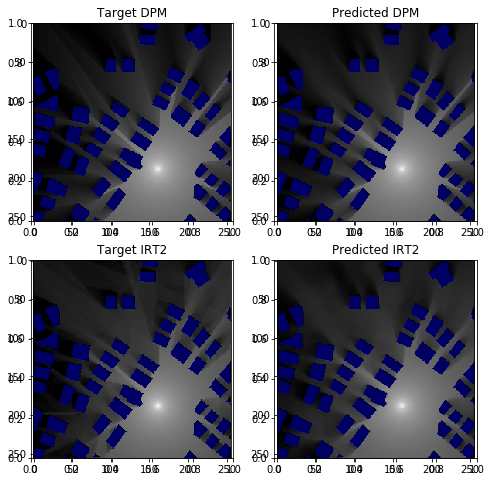

In [71]:

fig, axarr = plt.subplots(2,2, figsize=(8, 8))


im=io.imread("RadioWNet_c_DPM_Thr2/Examples/17_187_1DPM_target.png")
fig.add_subplot(2, 2, 1)
plt.imshow(im)
axarr[0, 0].set_title('Target DPM')

im=io.imread("RadioWNet_c_DPM_Thr2/Examples/17_187_1DPM_predict.png")
fig.add_subplot(2, 2, 2)
plt.imshow(im)
axarr[0, 1].set_title('Predicted DPM')

im=io.imread("RadioWNet_c_DPM_Thr2/Examples/17_187_1IRT4_target.png")
fig.add_subplot(2, 2, 3)
plt.imshow(im)
axarr[1, 0].set_title('Target IRT2')

im=io.imread("RadioWNet_c_DPM_Thr2/Examples/17_187_1IRT4_predict.png")
fig.add_subplot(2, 2, 4)
plt.imshow(im)
axarr[1, 1].set_title('Predicted IRT2')

Text(0.5, 1.0, 'Predicted IRT2')

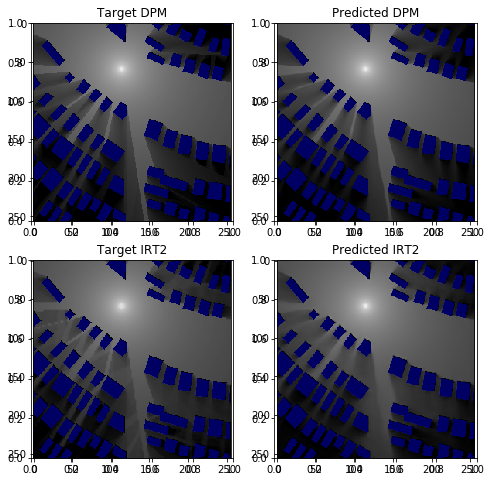

In [81]:

fig, axarr = plt.subplots(2,2, figsize=(8, 8))


im=io.imread("RadioWNet_c_DPM_Thr2/Examples/41_508_2DPM_target.png")
fig.add_subplot(2, 2, 1)
plt.imshow(im)
axarr[0, 0].set_title('Target DPM')

im=io.imread("RadioWNet_c_DPM_Thr2/Examples/41_508_2DPM_predict.png")
fig.add_subplot(2, 2, 2)
plt.imshow(im)
axarr[0, 1].set_title('Predicted DPM')

im=io.imread("RadioWNet_c_DPM_Thr2/Examples/41_508_2IRT4_target.png")
fig.add_subplot(2, 2, 3)
plt.imshow(im)
axarr[1, 0].set_title('Target IRT2')

im=io.imread("RadioWNet_c_DPM_Thr2/Examples/41_508_2IRT4_predict.png")
fig.add_subplot(2, 2, 4)
plt.imshow(im)
axarr[1, 1].set_title('Predicted IRT2')

Text(0.5, 1.0, 'Predicted IRT2')

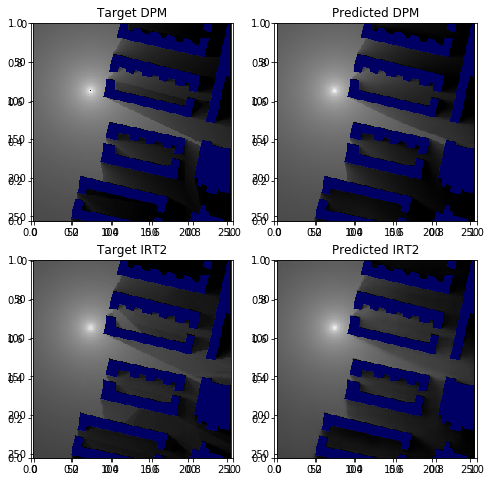

In [73]:

fig, axarr = plt.subplots(2,2, figsize=(8, 8))


im=io.imread("RadioWNet_c_DPM_Thr2/Examples/31_476_2DPM_target.png")
fig.add_subplot(2, 2, 1)
plt.imshow(im)
axarr[0, 0].set_title('Target DPM')

im=io.imread("RadioWNet_c_DPM_Thr2/Examples/31_476_2DPM_predict.png")
fig.add_subplot(2, 2, 2)
plt.imshow(im)
axarr[0, 1].set_title('Predicted DPM')

im=io.imread("RadioWNet_c_DPM_Thr2/Examples/31_476_2IRT4_target.png")
fig.add_subplot(2, 2, 3)
plt.imshow(im)
axarr[1, 0].set_title('Target IRT2')

im=io.imread("RadioWNet_c_DPM_Thr2/Examples/31_476_2IRT4_predict.png")
fig.add_subplot(2, 2, 4)
plt.imshow(im)
axarr[1, 1].set_title('Predicted IRT2')